# Mushrooms: to eat or not to eat, that is the question

Progetto di Programmazione di Applicazioni Data Intensive a.a. 2019/20<br>
<br>
**Realizzato da**: Yuqi Sun<br>
yuqi.sun@studio.unibo.it<br>
826197
<br>

In questo progetto si vuole prevedere la commestibilità dei funghi date alcune loro caratteristiche. Il dataset preso in considerazione includono funghi appartenenti a 23 specie diverse di `funghi lamellati` (funghi dell'ordine `Agaricales`) dei geni `Agaricus` e `Lepiota`.

Ogni specie è classificata come `commestibile`, `velenoso`, `commestibilità ignota` e `non raccomandato`. Gli ultimi due tipi sono stati uniti con quelli velenosi.

Di seguito si importano le librerie necessarie.

In [1]:
#pip install git+https://github.com/shakedzy/dython.git

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import scipy.stats as ss

from collections import Counter
from dython.nominal import associations
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import KernelPCA

<br><br><br>
## 1. Caricamento dei dati

Il dataset presenta le seguenti features:
- `class`: indica se il fungo è commestibile o meno
- `cap-shape`: forma del cappello
- `cap-surface`: superficie del cappello
- `cap-color`: colore del cappello
- `bruises`: presenza di macchie/lividi
- `odor`: odore del fungo
- `gill-attachment`: attaccature delle lamelle
- `gill-spacing`: distanza tra le lamelle
- `gill-size`: grandezza delle lamelle
- `gill-color`: colore delle lamelle
- `stalk-shape`: forma del gambo 
- `stalk-root`: radice del gambo 
- `stalk-surface-above-ring`: superficie del gambo sopra l'anello
- `stalk-surface-below-ring`: superficie del gambo sotto l'anello
- `stalk-color-above-ring`: colore del gambo sopra l'anello
- `stalk-color-below-ring`: colore del gambo sotto l'anello
- `veil-type`: tipo di velo 
- `veil-color`: colore del velo 
- `ring-number`: numero di anelli 
- `ring-type`: tipo di anello 
- `spore-print-color`: colore delle  sporata
- `population`: popolazione
- `habitat`: habitat

`class` è la feature da predire.

Per risparmiare memoria, si carica il dataset settando direttamente come tipo di dato `category`.

In [3]:
mushrooms = pd.read_csv('mushrooms.csv',  dtype='category')

In [4]:
mushrooms.head(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Per rendere il dataset più comprensibile, sostituiamo le varie sigle con il loro nome completo.

In [5]:
with open('full_labels.json', 'r') as fp:
    full_labels = json.load(fp)
    
mushrooms = mushrooms.apply(lambda ser: ser.replace(full_labels[ser.name]),
              axis=0).astype('category')

In [6]:
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


In [7]:
mushrooms.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Columns: 23 entries, class to habitat
dtypes: category(23)
memory usage: 189.0 KB


<br><br><br>
## 2. Analisi dei dati

Il dataset, composto da 8124 righe, non ha valori nulli ed è diviso abbastanza equamente in funghi commestibili e velenosi: 4208 contro i 3916, ovvero 292 in più di quelli velenosi.

In [8]:
mushrooms[mushrooms.isnull().any(axis=1)]

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat


edible       4208
poisonous    3916
Name: class, dtype: int64

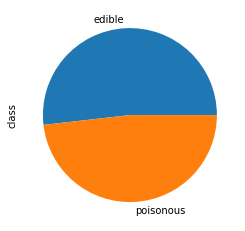

In [9]:
mushrooms['class'].value_counts().plot.pie(labels=['edible', 'poisonous'])
mushrooms['class'].value_counts()

### 2.1 Analisi delle features

Analizziamo adesso le varie features.

In [10]:
mushrooms.describe().T

,count,unique,top,freq
class,8124,2,edible,4208
cap-shape,8124,6,convex,3656
cap-surface,8124,4,scaly,3244
cap-color,8124,10,brown,2284
bruises,8124,2,no,4748
odor,8124,9,none,3528
gill-attachment,8124,2,free,7914
gill-spacing,8124,2,close,6812
gill-size,8124,2,broad,5612
gill-color,8124,12,buff,1728


`veil-type` presenta un unico valore: tutti i funghi hanno un velo di tipo `parziale` e non sono presenti funghi con velo `universale`. Il `veil-type` di un fungo, quindi, non ha rilevanza nel determinare la sua commestibilità e procediamo a eliminarlo dal dataset.

In [11]:
mushrooms.drop('veil-type', inplace=True,axis=1)

#### Forma del cappello
Il cappello di un fungo può essere a forma di campana, conico, convesso, piatto, a pomello o incavato (*inglese: bell = b, conical = c, convex = x, flat = f, knobbed = k, sunken = s*).

In [12]:
palette = ['#a6dcef', '#fb9090']
sns.set_palette(palette)

In [13]:
def getClassByFeature(features_name):
    df = pd.crosstab(mushrooms[features_name], mushrooms['class'], dropna=False)
    return df

In [14]:
getClassByFeature('cap-shape')                    

class,edible,poisonous
cap-shape,,
bell,404,48
conical,0,4
convex,1948,1708
flat,1596,1556
knobbed,228,600
sunken,32,0


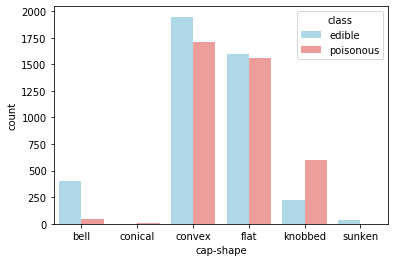

In [15]:
s = sns.countplot(x=mushrooms['cap-shape'], hue='class', data=mushrooms)

La maggior parte dei funghi hanno un cappello a forma `convessa` o `piatta`, a loro volta divisi abbastanza equamente in commestibili e velenosi. Gran parte dei funghi con un cappello a forma di `pomello` sono velenosi, mentre gran parte dei funghi a forma di `campana` sono commestibili. I 32 con il cappello `incavato` sono tutti commestibili, i 4 con il capello `conico` sono tutti velenosi.

#### Le altre features
Visualizziamo adesso le restanti features in modo simile.

In [16]:
features = mushrooms.drop(['class', 'cap-shape'], axis=1).columns

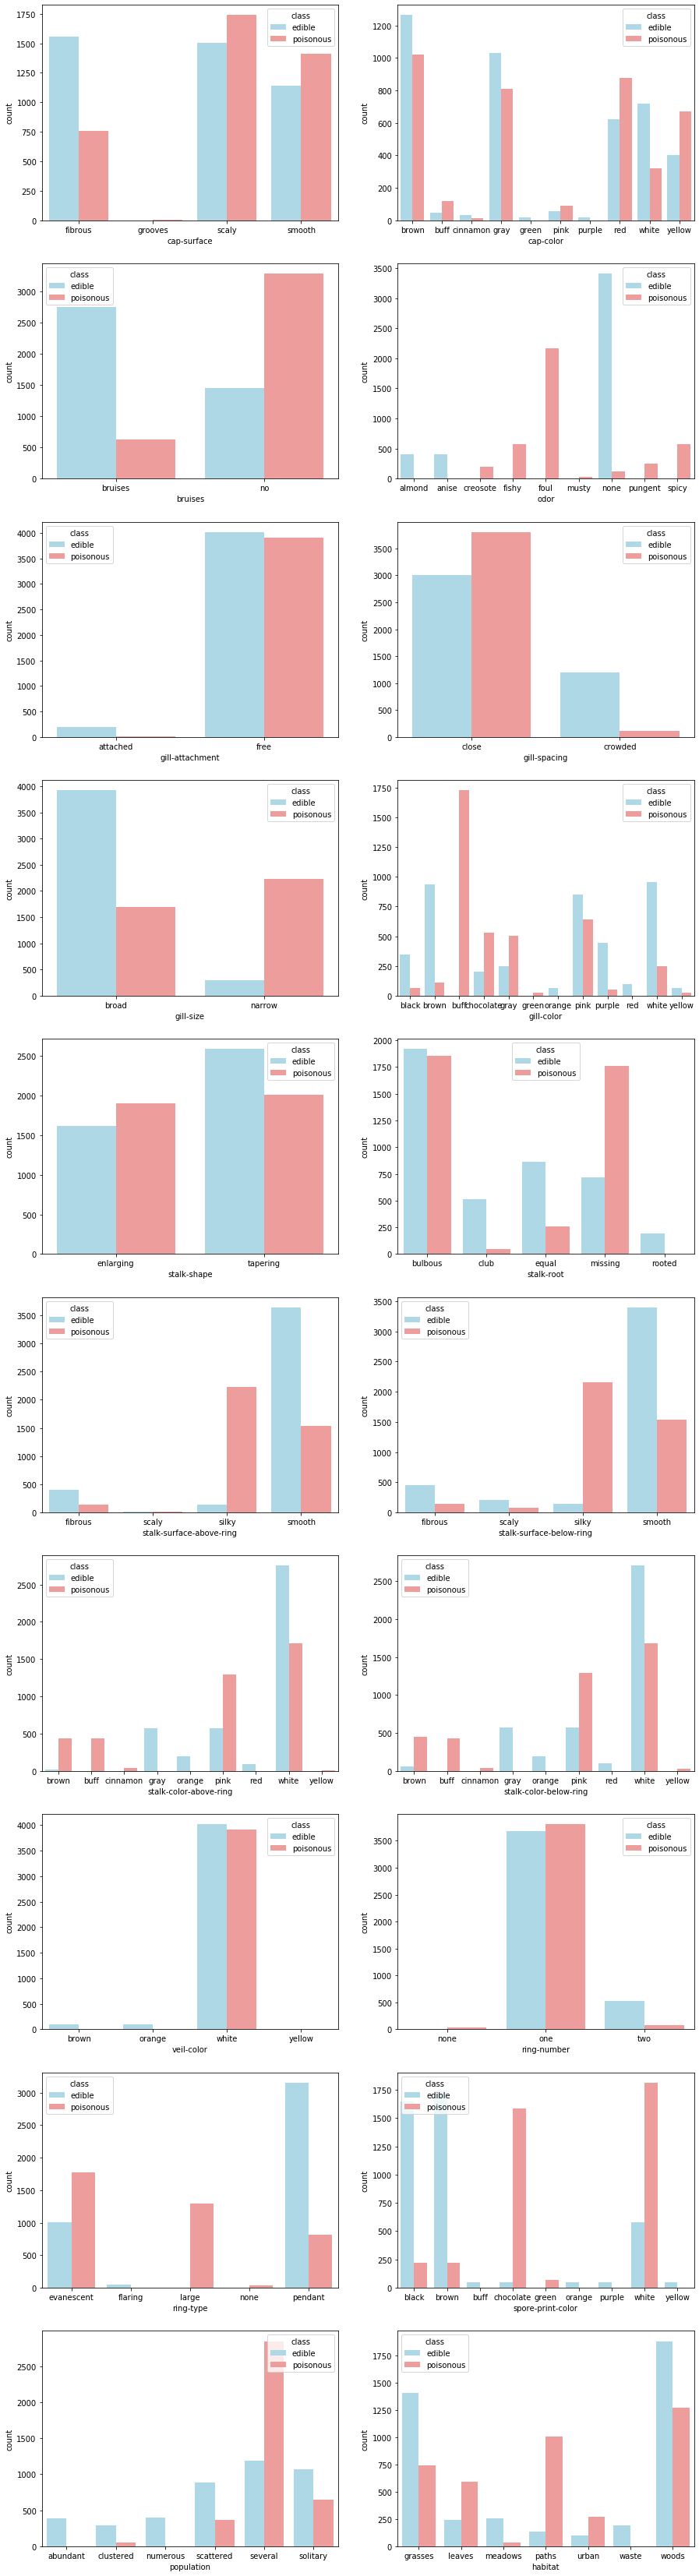

In [17]:
fig, axes = plt.subplots(10, 2, figsize=(15, 60))
for i, feature in enumerate(features):
    s = sns.countplot(x=mushrooms[feature], hue='class', data=mushrooms, ax=axes[int(i/2), round(i%2)])

Come si può notare dai vari grafici, non c'è una perfetta separazione tra le varie features. Alcune features, come `odor`, `spore-print-color` e `habitat`, presentano delle divari interessanti che possiamo analizzare più dettagliamente.

#### Odore
Un fungo può avere un odore di mandorla, anice, creosoto, di pesce, marcio, ammuffito, nessuno, pungente o speziato (*inglese: almond = a, anise = l, creosote = c, fishy = y, foul = f, musty = m, none = n, pungent = p, spicy = s*).

In [18]:
odor = getClassByFeature('odor')
odor

class,edible,poisonous
odor,,
almond,400,0
anise,400,0
creosote,0,192
fishy,0,576
foul,0,2160
musty,0,36
none,3408,120
pungent,0,256
spicy,0,576


In [19]:
odor[odor['edible'] == 0].sum()['poisonous']/mushrooms[mushrooms['class'] == 'poisonous'].shape[0] * 100

96.93564862104188

In [20]:
odor[odor['poisonous'] == 0].sum()['edible']/mushrooms[mushrooms['class'] == 'edible'].shape[0] * 100

19.011406844106464

In [21]:
3408/(3408+120)*100

96.5986394557823

Si possono mangiare con totale tranquillità i funghi con odore di `anice` o di `mandorla`, mentre quelli che non hanno odore tendono a essere commestibili, i restanti sono tutti velenosi. Possiamo quindi presupporre che l'odore di un fungo sia una feature molto importante per determinarne la sua commestibilità.

Infatti, usando soltanto l'odore, è possibile identificare quasi tutti i funghi velenosi (circa il `97%`) e circa il `20%` dei funghi commestibili. Di quelli senza odore, si possono mangiare il `96.5%`.

#### Colore delle sporata
La sporata di un fungo può avere i seguenti colori: nero, marrone, marrone chiaro, cioccolato, verde, arancione, viola, bianco, giallo (*inglese: black = k, brown = n, buff = b, chocolate = h, green = r, orange = o, purple = u, white = w, yellow = y*)

In [22]:
getClassByFeature('spore-print-color')

class,edible,poisonous
spore-print-color,,
black,1648,224
brown,1744,224
buff,48,0
chocolate,48,1584
green,0,72
orange,48,0
purple,48,0
white,576,1812
yellow,48,0


I funghi dalla sporata color `giallo`, `viola`, `arancione` o `marrone chiaro` sono tutti commestibili. Quelli con spurata `marrone` o `nero` sono in gran parte commestibili, mentre quelli con la spurata `bianca`, color `cioccolato` o `verde` sono per lo più velenosi.

#### Habitat
Un fungo può vivere in uno dei seguenti habitat: erba, foglie, pascolo, sentiero, urbano, rifiuti, boschi (*inglese:  grasses = g, leaves = l, meadows = m, paths = p, urban = u, waste = w, woods = d*)

In [23]:
getClassByFeature('habitat')

class,edible,poisonous
habitat,,
grasses,1408,740
leaves,240,592
meadows,256,36
paths,136,1008
urban,96,272
waste,192,0
woods,1880,1268


I funghi commestibili sono leggermente più diffusi in habitat come `boschi`, `prati` e `pascoli`, ma meno diffusi nei `sentieri`, `foglie` e habitat `urbani`. Tutti i 192 funghi in habitat di `rifiuti` sono commestibili.

<br><br><br>
## 3. Preparazione dei dati

Esistono features dove il numero di funghi commestibili e velenosi sono più o meno uguali o semplicemente non presentano un'alta variabilità (es: `gill-attachment`, `stalk-shape`, `veil-color`, `ring-number`). Prima di procedere alla creazione dei nostri modelli quindi, passiamo alla scelta delle feature più rilevanti.

Analizziamo quindi la correlazione presente tra le varie features. Per calcolare la correlazione di un dataset categorico, invece dell'`indice di Pearson`, si possono usare `Cramér’s V` o `Theil's U`, detto anche `coefficiente d'incertezza` (Uncertainty Coefficient). Similmente alla correlazione, l'output di questi due coefficienti vanno da `0 a 1`, dove 0 significa che **non c'è** associazione, mentre 1 significa che **c'è** associazione;  `Cramér’s V`, come Pearson, è simmetrico, mentre `Theil's U` non è simmetrico.
Nel nostro caso, useremo `Theil's U`: infatti, sapere l'odore di un fungo o il suo habitat ci può dare molte informazioni riguardo la sua classe, mentre non è vero il contrario.

Per usare il coefficiente di Theil's U useremo la libreria `dython` (https://github.com/shakedzy/dython).

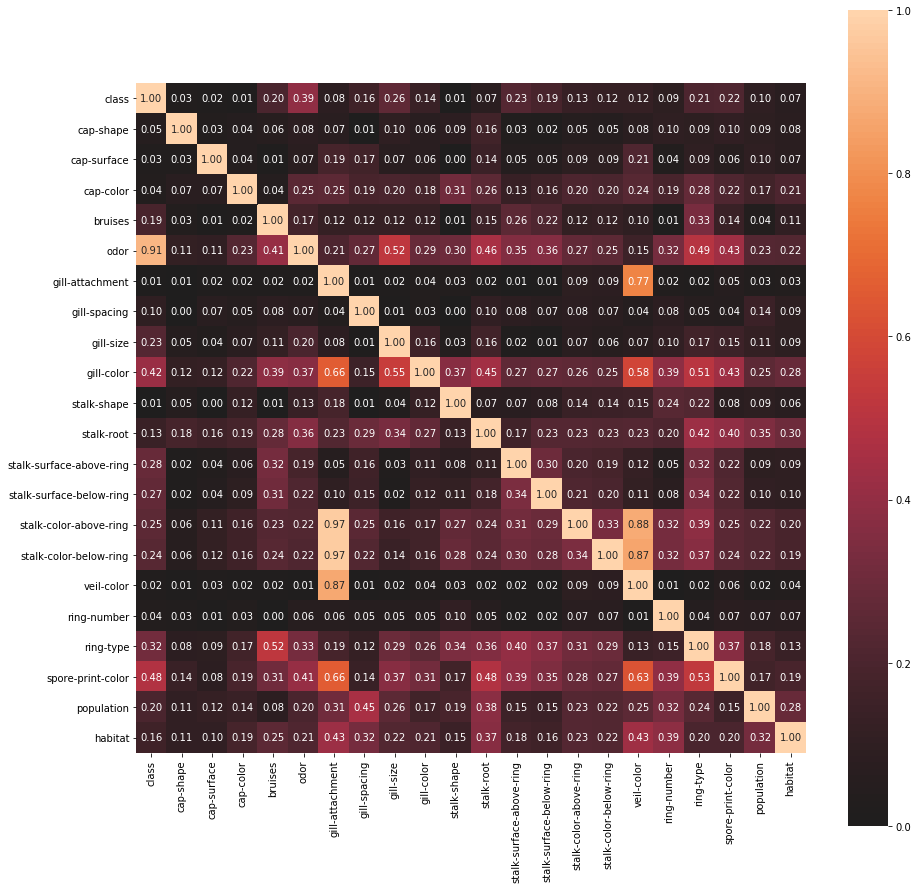

In [24]:
output = associations(mushrooms, nan_strategy='drop_samples', theil_u=True, figsize=(15, 15))

In [25]:
output['corr'].sort_values(by=['class'], ascending=False).iloc[:, 0]

class                       1.000000
odor                        0.906920
spore-print-color           0.481153
gill-color                  0.417367
ring-type                   0.318318
stalk-surface-above-ring    0.284991
stalk-surface-below-ring    0.272148
stalk-color-above-ring      0.254082
stalk-color-below-ring      0.241641
gill-size                   0.230369
population                  0.202146
bruises                     0.192559
habitat                     0.156980
stalk-root                  0.134943
gill-spacing                0.100977
cap-shape                   0.048842
ring-number                 0.038489
cap-color                   0.036083
cap-surface                 0.028617
veil-color                  0.023839
gill-attachment             0.014178
stalk-shape                 0.007524
Name: class, dtype: float64

Data la loro scarsa influeza, scegliamo di eliminare le features che hanno un coefficiente minore di `0.1`.

In [26]:
mushrooms.drop(['cap-shape', 'ring-number', 'cap-color', 'cap-surface',
                'veil-color', 'gill-attachment', 'stalk-shape'], axis=1, inplace=True)

In [27]:
mushrooms.head()

,class,bruises,odor,gill-spacing,gill-size,gill-color,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-type,spore-print-color,population,habitat
0,poisonous,bruises,pungent,close,narrow,black,equal,smooth,smooth,white,white,pendant,black,scattered,urban
1,edible,bruises,almond,close,broad,black,club,smooth,smooth,white,white,pendant,brown,numerous,grasses
2,edible,bruises,anise,close,broad,brown,club,smooth,smooth,white,white,pendant,brown,numerous,meadows
3,poisonous,bruises,pungent,close,narrow,brown,equal,smooth,smooth,white,white,pendant,black,scattered,urban
4,edible,no,none,crowded,broad,black,equal,smooth,smooth,white,white,evanescent,brown,abundant,grasses


Di tutte le features, l'`odore` è quello che contraddistingue maggiormente un fungo commestibile da uno velenoso. Ricordando la tabella di prima, un fungo dall'odore di anice o di mandorla è sicuramente commestibile, mentre qualunque altro odore ne indica la non commestibilità. Più ambiguo è, invece, un fungo che non ha odore.
Scegliamo quindi di eliminare anche l'odore dal nostro dataset e lavorare solamente con le restanti features.

In [28]:
no_odor = mushrooms.drop('odor', axis=1)

Per finire, dividiamo il nostro dataset.

In [29]:
X = no_odor.drop('class', axis=1)
y = np.where(no_odor['class'] == 'edible', 1, 0)

In [30]:
X.describe()

,bruises,gill-spacing,gill-size,gill-color,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,2,2,12,5,4,4,9,9,5,9,6,7
top,no,close,broad,buff,bulbous,smooth,smooth,white,white,pendant,white,several,woods
freq,4748,6812,5612,1728,3776,5176,4936,4464,4384,3968,2388,4040,3148


In [31]:
y

array([0, 1, 1, ..., 1, 0, 1])

**Attenzione: 1 = commestibile, 0 = velenoso**

<br><br><br>
## 4. Generazione dei modelli

### 4.1 Utility function

In [32]:
classes = ["poisonous", "edible"]
features = X.columns
max_it = 10000
bold = '\033[1m'
end = '\033[0m'

In [33]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

def confidence_interval(model, X_val, y_val, level=0.95):
    a = model.score(X_val, y_val)
    N = X_val.shape[0]
    Z = norm.ppf((1 + level) / 2)
    lower, upper = conf_interval(a, N, Z)
    print('\nConfidence interval with {}% confidence: \nMin: {:.4}% \nMax: {:.4}%'.format(level, lower, upper))

In [34]:
def plot_confusion_matrix(y_val, y_pred):
    print(bold + '\n\nCONFUSION MATRIX' + end)
    cm = confusion_matrix(y_val, y_pred)
    df = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df, annot=True, fmt='d', annot_kws={'size': 14})
    plt.ylabel('True values')
    plt.xlabel('Predicted values')
    plt.show()

In [35]:
def plot_features(model, model_index, encoder_index):
    print(bold + '\n\nFEATURES: top and bottom 5' + end)
    df = pd.Series(model.best_estimator_[model_index].coef_[0],
                   model.best_estimator_[encoder_index].get_feature_names(features)).sort_values(ascending=False)
    
    plt.subplot(2, 1 , 1)
    df.head(5).plot(kind='barh', figsize=(10, 5))
    
    plt.subplot(2, 1 , 2)
    df.tail(5).plot(kind='barh')
    
    return df

In [36]:
def model_info(model, X_val, y_val, preds):
    print(bold + '\n\nMODEL INFO\n' + end)
    print(classification_report(y_val, preds))
    print('Mean squared error: {:.5}'.format(mean_squared_error(y_val, preds)))
    print('Mean R-squared coefficient: {:.5}'.format(model.score(X_val, y_val)))

In [37]:
def gridsearch_info(model, X_val, y_val, parameters):
    print(bold + '\nGRID SEARCH INFO\n' + end)
    print('Best Parameters: ', model.best_params_)
    print('\nBest train score: ', model.best_score_)
    print('Best validation score: ', model.score(X_val, y_val))

In [38]:
def print_all(model, X_val, y_val, parameters=None, pipeline=True):
    preds = model.predict(X_val)
    if (pipeline):
        gridsearch_info(model, X_val, y_val, parameters)
    model_info(model, X_val, y_val, preds)
    confidence_interval(model, X_val, y_val)
    plot_confusion_matrix(y_val, preds)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
skf = StratifiedKFold(3, shuffle=True, random_state=42)

### 4.2 Logistic Regression


GRID SEARCH INFO

Best Parameters:  {'encoder': OneHotEncoder(), 'lr__C': 10, 'lr__penalty': 'l1'}

Best train score:  0.9903986813218276
Best validation score:  0.9867060561299852


MODEL INFO

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1316
           1       0.99      0.98      0.99      1392

    accuracy                           0.99      2708
   macro avg       0.99      0.99      0.99      2708
weighted avg       0.99      0.99      0.99      2708

Mean squared error: 0.013294
Mean R-squared coefficient: 0.98671

Confidence interval with 0.95% confidence: 
Min: 0.9817% 
Max: 0.9904%


CONFUSION MATRIX


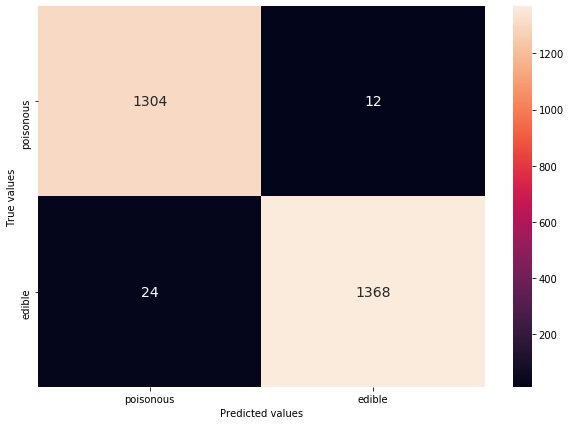

In [40]:
#max iter was added to get rid of convergence warning
lr = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('lr', LogisticRegression(solver='saga', max_iter=max_it, random_state=42))
])

lr_grid = [
    {
        'encoder': [OneHotEncoder(), OrdinalEncoder()],
        'lr__penalty': ['l1', 'l2'],
        'lr__C':  [10, 1, 0.5]
    },
    {   
        'encoder': [OneHotEncoder(), OrdinalEncoder()],
        'lr__penalty': ['elasticnet'],
        'lr__C': [1.2, 1, 0.5],
        'lr__l1_ratio': [0.1, 0.2, 0.5]
    }
]
lr_p = ['param_encoder', 'param_lr__penalty', 'param_lr__C', 'param_lr__l1_ratio', 'mean_test_score']
lr_gs = GridSearchCV(lr, lr_grid, cv=skf)
lr_gs.fit(X_train, y_train)
print_all(lr_gs, X_val, y_val, lr_p)



FEATURES: top and bottom 5


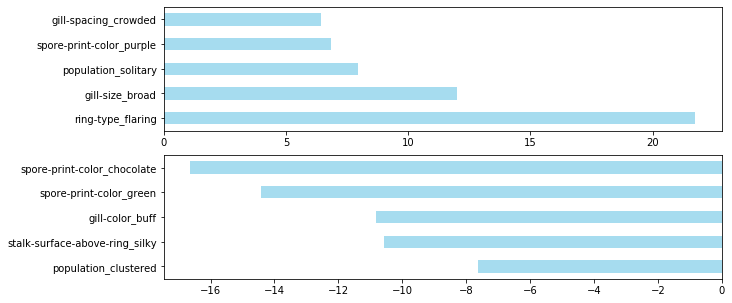

In [41]:
lr_coeff = plot_features(lr_gs, 1, 0)

### 4.3 Perceptron


GRID SEARCH INFO

Best Parameters:  {'encoder': OneHotEncoder(), 'pt__alpha': 1e-05, 'pt__penalty': 'l1'}

Best train score:  0.9900292346533409
Best validation score:  0.9918759231905465


MODEL INFO

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1316
           1       0.99      0.99      0.99      1392

    accuracy                           0.99      2708
   macro avg       0.99      0.99      0.99      2708
weighted avg       0.99      0.99      0.99      2708

Mean squared error: 0.0081241
Mean R-squared coefficient: 0.99188

Confidence interval with 0.95% confidence: 
Min: 0.9877% 
Max: 0.9946%


CONFUSION MATRIX


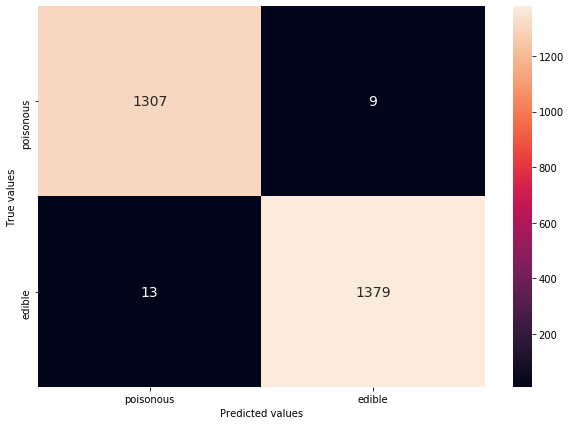

In [42]:
#max iter was added to get rid of convergence warning
pt = Pipeline([
    ('encoder', OneHotEncoder()),
    ('pt', Perceptron(max_iter=max_it))
])

pt_grid = {
    'encoder': [OneHotEncoder(), OrdinalEncoder()],
    'pt__penalty': ['l1', 'l2', 'elasticnet'],
    'pt__alpha':  [1e-9, 1e-5, 1e-1]
}

pt_p = ['param_encoder', 'param_pt__penalty', 'param_pt__alpha', 'mean_test_score']
pt_gs = GridSearchCV(pt, pt_grid, cv=skf)
pt_gs.fit(X_train, y_train)
print_all(pt_gs, X_val, y_val, pt_p)



FEATURES: top and bottom 5


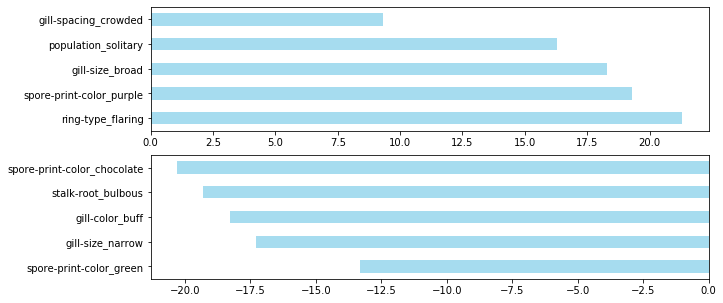

In [43]:
pt_coeff = plot_features(pt_gs, 1, 0)

### 4.4 MLPClassifier


GRID SEARCH INFO

Best Parameters:  {'encoder': OneHotEncoder()}

Best train score:  1.0
Best validation score:  1.0


MODEL INFO

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1316
           1       1.00      1.00      1.00      1392

    accuracy                           1.00      2708
   macro avg       1.00      1.00      1.00      2708
weighted avg       1.00      1.00      1.00      2708

Mean squared error: 0.0
Mean R-squared coefficient: 1.0

Confidence interval with 0.95% confidence: 
Min: 0.9986% 
Max: 1.0%


CONFUSION MATRIX


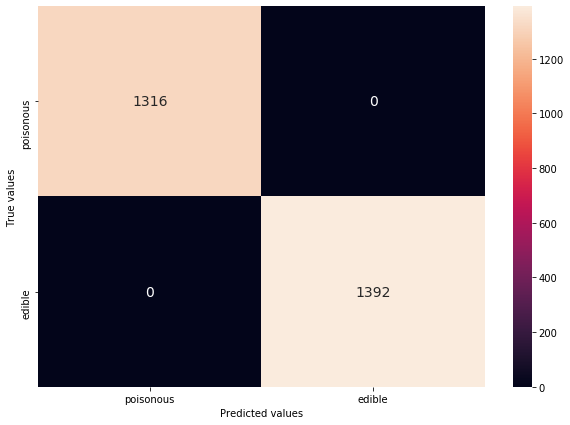

In [44]:
#max iter was added to get rid of convergence warning
mlp = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('mlp', MLPClassifier(hidden_layer_sizes=25, random_state=42,max_iter=500, activation='relu')),
])

mlp_grid = {
    'encoder': [OneHotEncoder(), OrdinalEncoder()]
}

mlp_p = ['param_encoder', 'mean_test_score']
mlp_gs = GridSearchCV(mlp, mlp_grid, cv=skf)
mlp_gs.fit(X_train, y_train)
print_all(mlp_gs, X_val, y_val)

### 4.5 Considerazioni

In [45]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

def print_model_diff(m1_name, m2_name, m1, m2, X, y):
    print(' {} vs {}: {}'.format(m1_name, m2_name, model_diff_interval(m1, m2, X, y)))

In [46]:
print_model_diff('LogistiRegression', 'Perceptron', lr_gs, pt_gs, X_val, y_val)
print_model_diff('LogistiRegression', 'MLPClassifier', lr_gs, mlp_gs, X_val, y_val)
print_model_diff('MLPClassifier', 'Perceptron', mlp_gs, pt_gs, X_val, y_val)

 LogistiRegression vs Perceptron: (-0.0003108635462667417, 0.010650597667389398)
 LogistiRegression vs MLPClassifier: (0.008980297110193516, 0.01760759062983611)
 MLPClassifier vs Perceptron: (0.004743121379977194, 0.011505032238929774)


Tutti e tre i modelli producono ottimi risultati. In tutti i modelli è stato preferito OneHotEncoder al posto di OrdinalEncoder.

I top 5 coefficienti presenti sia nel LogisticRegression sia nel Perceptron sono:`spore-print-color`, `gill-spacing`, `ring-type`, `population`, `gill-size`.

<br><br><br>
## 5. Classificazione funghi: features essenziali

Abbiamo visto che l'odore è una caratteristica molto importante per determinare se un fungo si può mangiare o meno. Proviamo quindi a usare la LogisticRegression (il modello che ha dato lo score minore), dapprima usando soltanto l'odore, e dopo usando l'odore e le top 5 features determinate precedentemente per determinare le features essenziali per determinare se un fungo si può mangiare o meno.

### 5.1 Solo odore



MODEL INFO

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1316
           1       0.97      1.00      0.98      1392

    accuracy                           0.98      2708
   macro avg       0.99      0.98      0.98      2708
weighted avg       0.98      0.98      0.98      2708

Mean squared error: 0.015879
Mean R-squared coefficient: 0.98412

Confidence interval with 0.95% confidence: 
Min: 0.9787% 
Max: 0.9882%


CONFUSION MATRIX


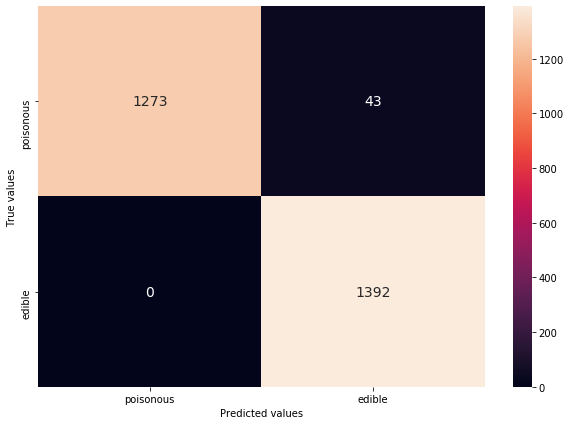

In [47]:
X2 = pd.DataFrame(mushrooms['odor'])
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y, test_size=1/3, random_state=42)
skf = StratifiedKFold(3, shuffle=True, random_state=42)

lr2 = Pipeline([
   ('encoder', OneHotEncoder()),
    ('lr', LogisticRegression(solver='saga', penalty='l1', C=10, max_iter=max_it, random_state=42))
])

lr2.fit(X2_train, y2_train)
print_all(lr2, X2_val, y2_val, None, False)

### 5.2 Odore e altre features

In [48]:
features = np.asarray(['odor', 'spore-print-color', 'gill-spacing', 'ring-type', 'population', 'gill-size'])
score = []

In [49]:
for i in range(len(features)):
    X3 = mushrooms[features[np.arange(len(features))!=i]]
    X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y, test_size=1/3, random_state=42)
    skf = StratifiedKFold(3, shuffle=True, random_state=42)

    lr = Pipeline([
        ('encoder', OneHotEncoder()),
        ('lr', LogisticRegression(solver='saga', penalty='l1', C=10, max_iter=max_it, random_state=42))
    ])

    lr.fit(X3_train, y3_train)
    score.append(lr.score(X3_val, y3_val))

In [50]:
score

[0.9826440177252584,
 0.9841211225997046,
 0.9948301329394387,
 1.0,
 0.9996307237813885,
 0.9933530280649926]

### 5.3 Senza ring-type

Togliendo `ring-type` otteniamo comunque uno score di `1.0` con la `logistic regression`. Ripredendo la heatmap delle correlazioni tra features, osserviamo che tra `odor` e `ring-type` c'è una correlazione del **0.49**, mentre tra `spore-print-color` e `ring-type` c'è una correlazione del **0.53**.

Procediamo adesso a sviluppare un nuovo modello con le 5 features rimanenti.



MODEL INFO

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1316
           1       1.00      1.00      1.00      1392

    accuracy                           1.00      2708
   macro avg       1.00      1.00      1.00      2708
weighted avg       1.00      1.00      1.00      2708

Mean squared error: 0.0
Mean R-squared coefficient: 1.0

Confidence interval with 0.95% confidence: 
Min: 0.9986% 
Max: 1.0%


CONFUSION MATRIX


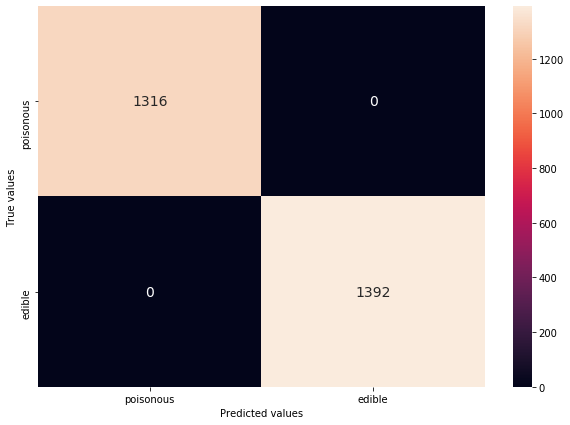

In [51]:
X4 = mushrooms[['odor', 'spore-print-color', 'gill-spacing', 'population', 'gill-size']]
X4_train, X4_val, y4_train, y4_val = train_test_split(X4, y, test_size=1/3, random_state=42)
skf = StratifiedKFold(3, shuffle=True, random_state=42)

lr = Pipeline([
    ('encoder', OneHotEncoder()),
    ('lr', LogisticRegression(solver='saga', penalty='l1', C=10, max_iter=max_it, random_state=42))
])

lr.fit(X4_train, y4_train)
print_all(lr, X4_val, y4_val, None, False)

In [52]:
pd.Series(lr.named_steps['lr'].coef_[0],
                   lr.named_steps['encoder'].get_feature_names(X4.columns)).sort_values(ascending=False)

odor_none                      13.644997
gill-size_broad                10.795069
gill-spacing_crowded            6.128678
odor_almond                     5.457467
odor_anise                      5.353055
spore-print-color_purple        0.306385
spore-print-color_brown         0.201642
population_several              0.159978
population_solitary             0.131099
odor_pungent                    0.000000
odor_spicy                      0.000000
spore-print-color_black         0.000000
spore-print-color_buff          0.000000
spore-print-color_chocolate     0.000000
odor_musty                      0.000000
spore-print-color_orange        0.000000
odor_fishy                      0.000000
spore-print-color_yellow        0.000000
population_abundant             0.000000
population_numerous             0.000000
population_scattered            0.000000
gill-spacing_close             -1.844697
odor_creosote                  -6.443736
gill-size_narrow               -6.511033
population_clust

## 6. Conclusioni

Usando soltanto l'odore è possibile identificare quasi tutti i funghi velenosi (circa il `97%`) e circa il `20%` dei funghi commestibili; inoltre si possono comunque mangiare il `96.5%` tra i funghi inodore. In mancanza di odore, si può osservare il colore della sporata, la distanza e la grandezza delle lamelle e il suo tipo di popolazione.

In generale:
- predilire i funghi dall'odore di mandorla o anice ed evitare tutti quelli che hanno altri tipi di odori
- in caso non abbiano odore:
    - *grandezza delle lamette*: funghi con lamette larghe sono tendenzialmente commestibili, quelle strette velenose
    - *distanza tra le lamette*: le lamette molto affollate tra loro sono generalmente commestibili
    - *colore della sporata*: evitare le sporate bianche e verdi
    
In ogni caso è sembre bene consulatre esperti.